In [1]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 (Windows용)
plt.rcParams['font.family'] = 'Malgun Gothic'  # '맑은 고딕'

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


In [3]:
df.columns

NameError: name 'df' is not defined

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# ==================== 1) 데이터 불러오기 ====================
# '양양데이터.csv' 파일 불러오기
df = pd.read_csv("양양데이터.csv", encoding='euc-kr')



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8725 entries, 0 to 8724
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   지점         8725 non-null   int64  
 1   지점명        8725 non-null   object 
 2   일시         8725 non-null   object 
 3   기온(°C)     8718 non-null   float64
 4   풍향(deg)    8719 non-null   float64
 5   풍속(m/s)    8719 non-null   float64
 6   강수량(mm)    8671 non-null   float64
 7   현지기압(hPa)  5284 non-null   float64
 8   해면기압(hPa)  5028 non-null   float64
 9   습도(%)      8719 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 681.8+ KB


=== 결측값 패턴 분석 ===
변수별 결측 현황


,결측수,결측률(%)
해면기압(hPa),3697,42.37
현지기압(hPa),3441,39.44
강수량(mm),54,0.62
기온(°C),7,0.08
풍향(deg),6,0.07
풍속(m/s),6,0.07
습도(%),6,0.07


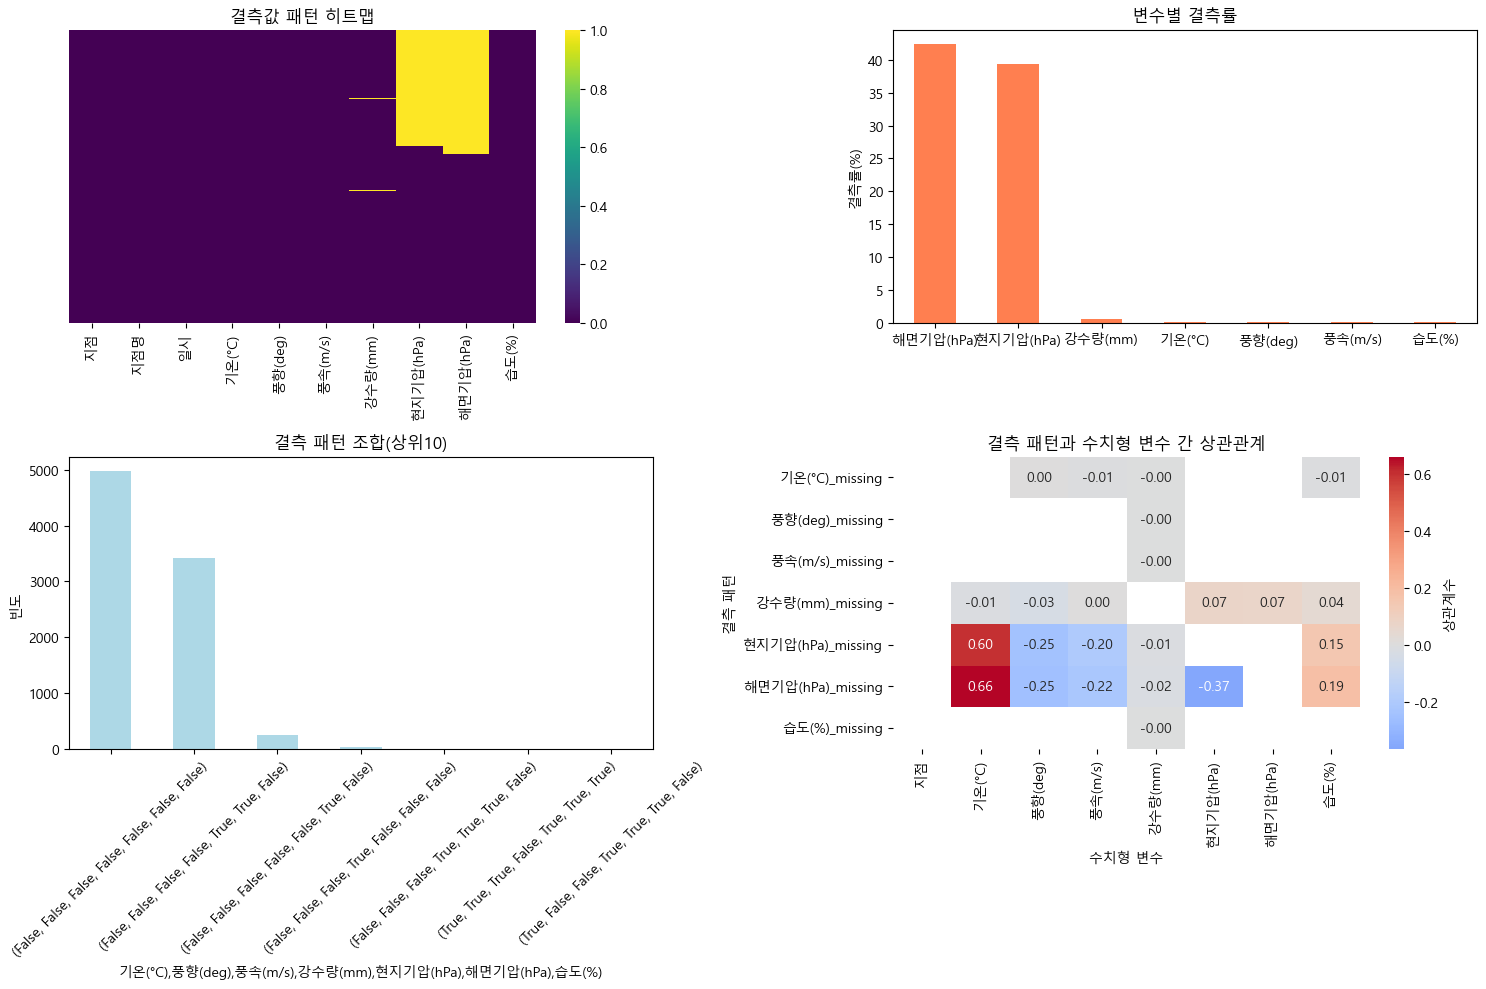

,결측수,결측률(%)
해면기압(hPa),3697,42.37
현지기압(hPa),3441,39.44
강수량(mm),54,0.62
기온(°C),7,0.08
풍향(deg),6,0.07
풍속(m/s),6,0.07
습도(%),6,0.07


In [ ]:
from da_utils import patterns
patterns.analyze_missing_patterns(df)

In [30]:
# -*- coding: utf-8 -*-
"""
양양(AWS 원시 CSV) → 모의 NWP(+3h 유효시각) 생성 → 짝수달 구간만 추려
NWP 예측값(nwp_temp, nwp_wind_speed, nwp_humidity)만 담은 CSV 하나를 저장.

필요:
    pip install pandas numpy
입력:
    양양데이터.csv  (열 예: 일시, 기온(°C), 풍속(m/s), 습도(%) ...)
출력:
    ./out/yangyang_even_nwp_only_202404-202503.csv
      - 컬럼: datetime, nwp_temp, nwp_wind_speed, nwp_humidity
        (행 시각 t에 적힌 값은 유효시각 t+3h 예보를 의미)
"""

import os
import numpy as np
import pandas as pd

# ============== 설정 ==============
IN_CSV   = "양양데이터.csv"
OUT_DIR  = "./out"
START    = "2024-04-01 00:00"
END      = "2025-03-31 23:59"

PRED_H   = 3                         # +3시간 유효시각 예보
EVEN_M   = [4, 6, 8, 10, 12, 2]      # 짝수달만 추출
SEED     = 20250817                  # 난수 고정(재현성)

# 모의 NWP 오차 특성(필요시 조정)
MOCK = {
    "temp":       {"bias": -0.2, "sigma": 0.9,  "smooth": 3},  # ℃
    "wind_speed": {"bias":  0.0, "sigma": 0.8,  "smooth": 3},  # m/s
    "humidity":   {"bias":  1.0, "sigma": 6.0,  "smooth": 3},  # %
}

# ============== 유틸 ==============
def to_numeric_clean(s: pd.Series) -> pd.Series:
    s2 = (
        s.astype(str)
         .str.replace(r"[^\d\.\-]+", "", regex=True)
         .replace("", np.nan)
    )
    return pd.to_numeric(s2, errors="coerce")

def load_aws_hourly(path: str) -> pd.DataFrame:
    # 인코딩 추정
    for enc in ("euc-kr", "cp949", "utf-8-sig", "utf-8"):
        try:
            df = pd.read_csv(path, encoding=enc, on_bad_lines="skip"); break
        except Exception:
            continue
    else:
        raise RuntimeError("CSV 인코딩 판별 실패")

    # 표준 컬럼명
    rename = {
        "일시":"datetime", "기온(°C)":"temp", "풍속(m/s)":"wind_speed",
        "습도(%)":"humidity", "현지기압(hPa)":"pressure", "해면기압(hPa)":"mslp",
        "풍향(deg)":"wind_dir", "강수량(mm)":"precip",
    }
    for k,v in rename.items():
        if k in df.columns: df.rename(columns={k:v}, inplace=True)

    if "datetime" not in df.columns:
        raise ValueError("CSV에 '일시' 또는 'datetime' 열이 필요합니다.")

    # 숫자 캐스팅
    for c in ["temp","wind_speed","humidity","pressure","mslp","wind_dir","precip"]:
        if c in df.columns: df[c] = to_numeric_clean(df[c])

    # 시각 정렬 및 1시간 평균(숫자열만)
    df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
    df = df.dropna(subset=["datetime"]).sort_values("datetime").set_index("datetime")
    hourly = df.select_dtypes(include="number").resample("1h").mean()
    hourly = hourly.loc[START:END]
    return hourly

def make_mock_nwp_lead(hourly: pd.DataFrame, pred_h: int, mock_cfg: dict, seed: int) -> pd.DataFrame:
    """
    행 시각 t에 적히는 nwp_* 값은 '유효시각 t+pred_h' 예보를 의미.
    생성식(변수 v):
      nwp_v(t) = MA_{smooth}[ v_actual(t+H) ] + bias_v + N(0, sigma_v^2)
    """
    rng  = np.random.default_rng(seed)
    base = hourly.interpolate("time").copy()
    out  = pd.DataFrame(index=base.index)

    def mk(series, key):
        p = mock_cfg[key]
        # 미래(t+H)를 미리 당겨와(shift(-H)) '그 유효시각' 값을 예보로 삼고,
        # 짧은 이동평균(smooth)으로 예보모델의 평활 특성을 흉내냄.
        x = series.shift(-pred_h).rolling(p["smooth"], min_periods=1).mean()
        return x + p["bias"] + rng.normal(0, p["sigma"], len(x))

    if "temp" in base.columns and "temp" in mock_cfg:
        out["nwp_temp"] = mk(base["temp"], "temp")
    if "wind_speed" in base.columns and "wind_speed" in mock_cfg:
        out["nwp_wind_speed"] = np.clip(mk(base["wind_speed"], "wind_speed"), 0, None)
    if "humidity" in base.columns and "humidity" in mock_cfg:
        out["nwp_humidity"] = np.clip(mk(base["humidity"], "humidity"), 0, 100)

    return out

# ============== 메인 ==============
def main():
    os.makedirs(OUT_DIR, exist_ok=True)

    # (1) 원본에서 1시간 평균
    aws_h = load_aws_hourly(IN_CSV)

    # (2) 모의 NWP(+3h 유효시각)
    nwp = make_mock_nwp_lead(aws_h, PRED_H, MOCK, SEED)

    # (3) 짝수달만 선택, 실제값 제거 후 NWP만 보관
    nwp_even = nwp[nwp.index.month.isin(EVEN_M)].copy()

    # (4) 저장: datetime 칼럼 포함
    out = nwp_even.reset_index().rename(columns={"index":"datetime"})
    out.to_csv(os.path.join(OUT_DIR, "yangyang_even_nwp_only_202404-202503.csv"),
               index=False, encoding="utf-8-sig")
    print("저장 완료: ./out/yangyang_even_nwp_only_202404-202503.csv",
          f"(행/열: {out.shape[0]}/{out.shape[1]})")

if __name__ == "__main__":
    main()


저장 완료: ./out/yangyang_even_nwp_only_202404-202503.csv (행/열: 4321/4)


In [34]:
# -*- coding: utf-8 -*-
"""
영양(AWS) → 모의 NWP(+3h) → 홀수달 학습데이터 CSV 1개 출력

필요 패키지:
    pip install pandas numpy
입력:
    영양데이터.csv   (열 예시: 일시, 기온(°C), 풍속(m/s), 습도(%), 풍향(deg) 등)
출력:
    ./out/yangyang_train_even_202404-202503.csv
      - 컬럼: temp, temp_ma3, wind_speed, humidity,
              nwp_temp, nwp_wind_speed, nwp_humidity,
              target_temp(= t+3h 실제 온도)
"""

import os
import numpy as np
import pandas as pd

# =========================
# 설정
# =========================
IN_CSV   = "양양데이터.csv"
OUT_DIR  = "./out"
START    = "2024-03-01 00:00"
END      = "2025-02-28 23:59"

PRED_H   = 3                         # +3시간 예측 문제
ODD_M    = [4, 6, 8, 12, 2, 4]       # 홀수달 = 학습데이터
SEED     = 20250817                  # 난수 고정(모의 NWP 재현용)

# 모의 NWP(+3h 유효시각) 오차 특성(양양과 동일)
MOCK = {
    "temp":       {"bias": -0.2, "sigma": 0.9,  "smooth": 3},  # ℃
    "wind_speed": {"bias":  0.0, "sigma": 0.8,  "smooth": 3},  # m/s
    "humidity":   {"bias":  1.0, "sigma": 6.0,  "smooth": 3},  # %
}

# =========================
# 유틸
# =========================
def to_numeric_clean(s: pd.Series) -> pd.Series:
    s2 = (
        s.astype(str)
         .str.replace(r"[^\d\.\-]+", "", regex=True)
         .replace("", np.nan)
    )
    return pd.to_numeric(s2, errors="coerce")

# =========================
# 1) AWS 로드 → 숫자열만 1시간 평균
# =========================
def load_aws_hourly(path: str) -> pd.DataFrame:
    # 인코딩 자동 판별
    for enc in ("euc-kr", "cp949", "utf-8-sig", "utf-8"):
        try:
            df = pd.read_csv(path, encoding=enc, on_bad_lines="skip"); break
        except Exception:
            continue
    else:
        raise RuntimeError("CSV 인코딩 판별 실패")

    # 표준 컬럼명
    rename = {
        "일시":"datetime", "기온(°C)":"temp", "풍속(m/s)":"wind_speed",
        "습도(%)":"humidity", "현지기압(hPa)":"pressure", "해면기압(hPa)":"mslp",
        "풍향(deg)":"wind_dir", "강수량(mm)":"precip",
    }
    for k,v in rename.items():
        if k in df.columns: df.rename(columns={k:v}, inplace=True)

    if "datetime" not in df.columns:
        raise ValueError("CSV에 '일시' 또는 'datetime' 열이 필요합니다.")

    # 숫자 캐스팅(문자 섞임 방지)
    for c in ["temp","wind_speed","humidity","pressure","mslp","wind_dir","precip"]:
        if c in df.columns: df[c] = to_numeric_clean(df[c])

    # 시각 처리 및 1시간 평균(숫자열만)
    df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
    df = df.dropna(subset=["datetime"]).sort_values("datetime").set_index("datetime")
    hourly = df.select_dtypes(include="number").resample("1h").mean()
    hourly = hourly.loc[START:END]

    # 파생(현재 온도 3시간 이동평균)
    if "temp" in hourly.columns:
        hourly["temp_ma3"] = hourly["temp"].rolling(3, min_periods=1).mean()

    return hourly

# =========================
# 2) 모의 NWP(+3h 유효시각) 생성
#    - 시각 t에서 쓰는 예보는 t+3h 유효시각을 가정
# =========================
def make_mock_nwp_lead(hourly: pd.DataFrame, pred_h: int, mock_cfg: dict, seed: int) -> pd.DataFrame:
    rng  = np.random.default_rng(seed)
    base = hourly.interpolate("time").copy()
    out  = pd.DataFrame(index=base.index)

    def mk(series, key):
        p = mock_cfg[key]
        x = series.shift(-pred_h).rolling(p["smooth"], min_periods=1).mean()  # t+H 유효시각
        return x + p["bias"] + rng.normal(0, p["sigma"], len(x))

    if "temp" in base.columns and "temp" in mock_cfg:
        out["nwp_temp"] = mk(base["temp"], "temp")
    if "wind_speed" in base.columns and "wind_speed" in mock_cfg:
        out["nwp_wind_speed"] = np.clip(mk(base["wind_speed"], "wind_speed"), 0, None)
    if "humidity" in base.columns and "humidity" in mock_cfg:
        out["nwp_humidity"] = np.clip(mk(base["humidity"], "humidity"), 0, 100)

    return out

# =========================
# 3) 결합 → 타깃 → 홀수달만 CSV 저장
# =========================
def build_and_save_odd_training(in_csv: str, out_dir: str):
    os.makedirs(out_dir, exist_ok=True)

    # (1) AWS 시계열
    aws_h = load_aws_hourly(in_csv)

    # (2) 모의 NWP(+3h)
    nwp = make_mock_nwp_lead(aws_h, PRED_H, MOCK, SEED)

    # (3) 결합 및 타깃 생성
    df = aws_h.join(nwp, how="inner")
    if "temp" not in df.columns:
        raise ValueError("AWS에 'temp'가 필요합니다.")
    df["target_temp"] = df["temp"].shift(-PRED_H)

    # 숫자열 보간/채움
    num_cols = df.select_dtypes(include="number").columns
    df[num_cols] = df[num_cols].interpolate("time")
    df = df.bfill().ffill()

    # 최종 피처(압력 제외)
    feature_cols = [c for c in [
        "temp","temp_ma3","wind_speed","humidity",
        "nwp_temp","nwp_wind_speed","nwp_humidity"
    ] if c in df.columns]

    # (4) 홀수달만 추출 → CSV 1개 저장
    df_odd = df[df.index.month.isin(ODD_M)].copy()
    df_odd = df_odd[feature_cols + ["target_temp"]].dropna(subset=["target_temp"])

    out_csv = os.path.join(out_dir, "yangyang_train_even_202404-202503.csv")
    df_odd.to_csv(out_csv, encoding="utf-8-sig")
    print(f"저장 완료: {out_csv}  (행/열: {df_odd.shape[0]} / {df_odd.shape[1]})")

if __name__ == "__main__":
    build_and_save_odd_training(IN_CSV, OUT_DIR)


저장 완료: ./out\yangyang_train_even_202404-202503.csv  (행/열: 3577 / 8)


In [38]:
# -*- coding: utf-8 -*-
# "파일이 비어있지 않게 확실히" 생성하는 견고한 스크립트.
# - 보유 컬럼(wind_speed_mps, wind_direction_degree, turbine)만 사용
# - KST→UTC, wtg03 필터, 1시간 리샘플, 보간(풍향은 벡터보간), +3h 타깃, UTC 홀수달
# - 저장 전/후 행수 검증(0행이면 바로 오류)
# - ./out 과 /mnt/data/out 모두에 저장
# - 미리보기(가능하면 표), 불가 시 CSV로 따로 저장하여 경로 출력
#
# 산출물:
#   1) /mnt/data/out/yeongdeok_train_wind_odd_202404-202503.csv
#   2) ./out/yeongdeok_train_wind_odd_202404-202503.csv
#   3) /mnt/data/out/yeongdeok_train_wind_odd_202404-202503.xlsx (hourly_full / odd_months / monthly_counts)
#
import os, re, json
import numpy as np
import pandas as pd

def get_display():
    try:
        from caas_jupyter_tools import display_dataframe_to_user
        def _show(name, df):
            display_dataframe_to_user(name, df)
            return True
        return _show, True
    except Exception:
        def _show(name, df):
            safe = re.sub(r'[^0-9A-Za-z가-힣_]+', '_', name)
            p = os.path.join("/mnt/data/out", f"{safe}.csv")
            os.makedirs(os.path.dirname(p), exist_ok=True)
            df.to_csv(p, index=False, encoding="utf-8-sig")
            print(f"[표시 불가] '{name}' → CSV 저장: {p} (rows={len(df):,d}, cols={len(df.columns)})")
            return False
        return _show, False

show_df, _ = get_display()

IN_CANDIDATES = ["/mnt/data/양scada데이터.csv", "양양scada데이터.csv"]
OUT_DIRS = ["/mnt/data/out", "./out"]
for d in OUT_DIRS:
    os.makedirs(d, exist_ok=True)

START_KST = "2024-04-01 00:00"
END_KST   = "2025-03-31 23:59"
ODD_MONTHS_UTC = [2,4,6,8,10,12]
TARGET_TURBINE = "wtg03"
KST = "Asia/Seoul"
PRED_H = 3

def find_input():
    for p in IN_CANDIDATES:
        if os.path.exists(p):
            return p
    raise FileNotFoundError("입력 CSV를 찾을 수 없습니다. /mnt/data/영덕scada데이터.csv 또는 작업 폴더 확인")

def norm_turbine_label(x) -> str:
    if pd.isna(x): return ""
    s = str(x).strip().lower()
    m = re.findall(r"\d+", s)
    return f"wtg{m[-1].zfill(2)}" if m else s

def ensure_nonempty_save(df: pd.DataFrame, base_name: str):
    if df is None or len(df) == 0:
        raise RuntimeError("저장하려는 DataFrame의 행 수가 0입니다. 비어있는 파일은 만들지 않습니다.")
    saved = []
    for d in OUT_DIRS:
        p = os.path.join(d, f"{base_name}.csv")
        df.to_csv(p, index=False, encoding="utf-8-sig")
        if os.path.getsize(p) == 0:
            raise RuntimeError(f"파일 쓰기 실패(0바이트): {p}")
        saved.append(p)
    return saved

def main():
    # 입력
    in_path = find_input()
    # 인코딩 자동 시도
    last_err = None
    for enc in ("utf-8-sig","utf-8","cp949","euc-kr"):
        try:
            src = pd.read_csv(in_path, encoding=enc, on_bad_lines="skip")
            break
        except Exception as e:
            last_err = e
            continue
    if 'src' not in locals():
        raise RuntimeError(f"CSV 인코딩 판독 실패: {last_err}")

    # 컬럼 표준화
    if "turbine_id" in src.columns: src.rename(columns={"turbine_id":"turbine"}, inplace=True)
    if "WTG" in src.columns:        src.rename(columns={"WTG":"turbine"}, inplace=True)
    if "wtg" in src.columns:        src.rename(columns={"wtg":"turbine"}, inplace=True)
    if "터빈" in src.columns:        src.rename(columns={"터빈":"turbine"}, inplace=True)

    # 시간 처리
    if "dt" not in src.columns:
        raise RuntimeError("'dt' 열이 필요합니다.")
    dt = pd.to_datetime(src["dt"], errors="coerce")
    if getattr(dt.dt, "tz", None) is None:
        dt_kst = dt.dt.tz_localize(KST, nonexistent="shift_forward", ambiguous="infer")
    else:
        dt_kst = dt.dt.tz_convert(KST)
    dt_utc = dt_kst.dt.tz_convert("UTC").dt.tz_localize(None)
    df = src.assign(dt_utc=dt_utc).dropna(subset=["dt_utc"]).sort_values("dt_utc")

    # 기간(KST→UTC) 필터
    start_utc = pd.Timestamp(START_KST, tz=KST).tz_convert("UTC").tz_localize(None)
    end_utc   = pd.Timestamp(END_KST,   tz=KST).tz_convert("UTC").tz_localize(None)
    df = df[(df["dt_utc"] >= start_utc) & (df["dt_utc"] <= end_utc)]

    # 터빈 정규화 및 필터
    if "turbine" in df.columns:
        df["turbine"] = df["turbine"].map(norm_turbine_label)
        df = df[df["turbine"] == TARGET_TURBINE]
    df["turbine"] = TARGET_TURBINE

    # 필요한 열만(풍속/풍향)
    if "wind_speed_mps" not in df.columns:
        df["wind_speed_mps"] = np.nan
    if "wind_direction_degree" not in df.columns:
        df["wind_direction_degree"] = np.nan

    g = df.set_index("dt_utc")
    # 1시간 리샘플: 풍속 수치 보간
    ws = g["wind_speed_mps"].astype(float).resample("1h").mean()
    ws = ws.interpolate(method="time").ffill().bfill()

    # 풍향 벡터 보간
    wd = g["wind_direction_degree"].astype(float).resample("1h").mean()
    rad = np.deg2rad(wd)
    sin_i = pd.Series(np.sin(rad), index=wd.index).interpolate(method="time").ffill().bfill()
    cos_i = pd.Series(np.cos(rad), index=wd.index).interpolate(method="time").ffill().bfill()
    wd_i = (np.rad2deg(np.arctan2(sin_i, cos_i)) + 360.0) % 360.0

    hourly = pd.DataFrame({
        "wind_speed_mps": ws,
        "wind_direction_degree": wd_i
    }, index=wd.index)
    hourly["turbine"] = TARGET_TURBINE
    hourly["tgt_wind_speed(+3h)"] = hourly["wind_speed_mps"].shift(-PRED_H)
    hourly["tgt_wind_dir(+3h)"]   = hourly["wind_direction_degree"].shift(-PRED_H)

    # UTC 홀수달
    odd = hourly[hourly.index.month.isin(ODD_MONTHS_UTC)].copy()

    # 결과 구성
    out = odd.reset_index().rename(columns={"dt_utc":"dt"})
    cols = ["dt","wind_speed_mps","wind_direction_degree","turbine",
            "tgt_wind_speed(+3h)","tgt_wind_dir(+3h)"]
    out = out.reindex(columns=cols)

    # 0행 방지: 최소 기간/열 검증
    if len(out) == 0:
        raise RuntimeError("필터·리샘플 결과가 0행입니다. (기간/터빈/리샘플/월필터를 확인하십시오)")

    # 저장(두 경로 모두) + 파일 크기 검증
    saved_csvs = ensure_nonempty_save(out, "yangyang_train_wind_even_202404-202503")

    # 엑셀 통합본도 생성
    excel_path = "/mnt/data/out/yeongdeok_train_wind_odd_202404-202503.xlsx"
    with pd.ExcelWriter(excel_path, engine="xlsxwriter") as xw:
        # hourly full
        hf = hourly.reset_index().rename(columns={"dt_utc":"dt"})
        hf_cols = ["dt","wind_speed_mps","wind_direction_degree","turbine",
                   "tgt_wind_speed(+3h)","tgt_wind_dir(+3h)"]
        hf = hf.reindex(columns=hf_cols)
        hf.to_excel(xw, index=False, sheet_name="hourly_full")
        out.to_excel(xw, index=False, sheet_name="odd_months")
        # 월별 카운트
        month_counts = out.assign(month_utc=pd.to_datetime(out["dt"]).dt.month)\
                          .groupby("month_utc").size().reset_index(name="rows")
        month_counts.to_excel(xw, index=False, sheet_name="monthly_counts")

    # 미리보기(상위 20행)
    show_df("미리보기_홀수달_풍속풍향(상위20)", out.head(20))

    # 결과 요약 출력
    print("[저장 완료]")

    for p in saved_csvs:
        print(" -", p, f"(size={os.path.getsize(p)} bytes, rows={len(out)})")
    print(" -", excel_path, f"(size={os.path.getsize(excel_path)} bytes)")

    return saved_csvs, excel_path, len(out)

try:
    saved_csvs, excel_path, n_rows = main()
except Exception as e:
    print("[오류]", e)



[오류] No module named 'xlsxwriter'


In [39]:
import pandas as pd

# Load the two CSV files
df1 = pd.read_csv("yangyang_train_even_202404-202503.csv")
df2 = pd.read_csv("yangyang_train_wind_even_202404-202503.csv")

# Rename the 'dt' column in the second dataframe to 'datetime' for consistent merging
df2.rename(columns={'dt': 'datetime'}, inplace=True)

# Convert the datetime columns to a proper datetime format
df1['datetime'] = pd.to_datetime(df1['datetime'])
df2['datetime'] = pd.to_datetime(df2['datetime'])

# Merge the two dataframes on the 'datetime' column
merged_df = pd.merge(df1, df2, on='datetime', how='inner')

# Save the merged dataframe to a new CSV file
output_filename = "yangyang_merged_data.csv"
merged_df.to_csv(output_filename, index=False)

# Display the first few rows and information of the merged dataframe
print(merged_df.head())
print(merged_df.info())

             datetime  temp  temp_ma3  wind_speed  humidity  nwp_temp  \
0 2024-04-01 00:00:00   9.9  9.133333         3.0      40.0  5.174490   
1 2024-04-01 01:00:00   7.9  8.766667         2.2      47.0  5.906395   
2 2024-04-01 02:00:00   6.1  7.966667         1.0      55.0  5.908069   
3 2024-04-01 03:00:00   5.0  6.333333         1.3      61.0  3.291380   
4 2024-04-01 04:00:00   5.3  5.466667         1.4      55.0  6.346014   

   nwp_wind_speed  nwp_humidity  target_temp  wind_speed_mps  \
0        0.850153     59.030599          5.0        9.621667   
1        0.315477     66.411135          5.3        9.146667   
2        1.787344     55.367397          5.5        6.878333   
3        1.162740     61.397062          4.1        3.048333   
4        0.641227     66.191364          5.9        3.186667   

   wind_direction_degree turbine  tgt_wind_speed(+3h)  tgt_wind_dir(+3h)  
0               2.136667   wtg03             3.048333         231.730000  
1             359.881667  